In [1]:
%%capture
%pip install neqsim

#To check for methods in a Java object 
#from neqsim import methods

# Experimental data
Experimental data is collected.

In [2]:
import pandas as pd
expdata_df = pd.read_csv('../../../data/thermodynamics/heatcapacity/CO2.csv')
expdata_df

expdata_df = expdata_df.loc[expdata_df['Temperature (K)'] < 1300]
expdata_df

,Temperature (K),Cp (J/mol*K)
0,298,37.12
1,300,37.22
2,400,41.34
3,500,44.61
4,600,47.32
5,700,49.57
6,800,51.44
7,900,53.00
8,1000,54.30
9,1100,55.40


<Figure size 640x480 with 0 Axes>

/home/codespace/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


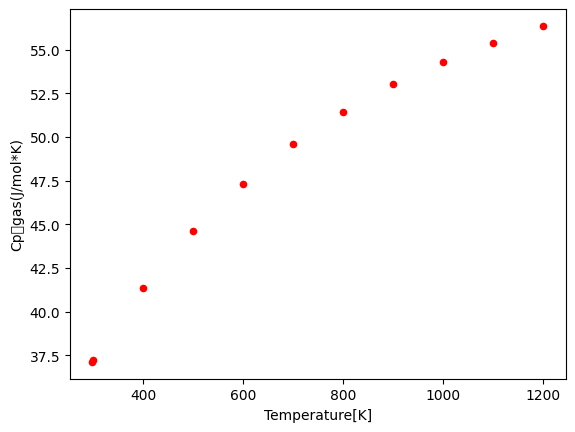

In [5]:
from matplotlib import pyplot as plt
fig = plt.figure()

expdata_df.plot(x='Temperature (K)', y='Cp (J/mol*K)', kind='scatter',ylabel='Cp	gas(J/mol*K)', xlabel='Temperature[K]',color='red')

plt.show()

# Evaluation of experimental data

In this section the experimental data will be evaluated and eventual some data sets will be removed from the set.

# Compare to NeqSim Calculations

## NeqSim calculations at 288.15 K

<Figure size 640x480 with 0 Axes>

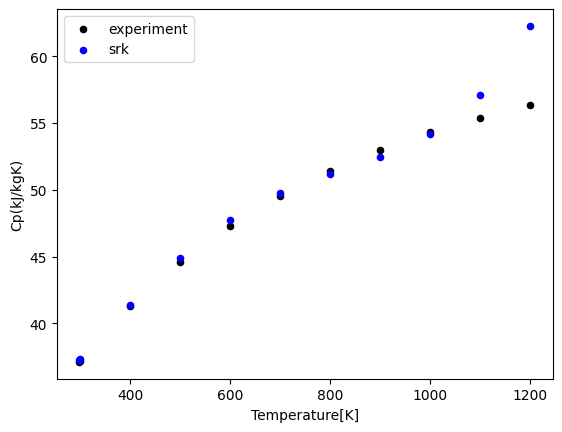

In [6]:
import neqsim
from neqsim.thermo.thermoTools import fluid, TPflash, fluidComposition,bubp
import pandas as pd
import numpy as np

fluid1 = fluid('srk')
fluid1.addComponent('CO2', 1.0)
fluid1.setTemperature(15.0, 'C')
fluid1.setPressure(1.0, 'bara')

def heatcap(input):
    fluid1.setTemperature(input[0], 'K')
    TPflash(fluid1)
    fluid1.initProperties()
    return fluid1.getPhase('gas').getCp('J/molK')

temperatures = expdata_df['Temperature (K)'].values.tolist()
expData = expdata_df['Cp (J/mol*K)'].values.tolist()
input = zip(temperatures)
cP_res = [heatcap(inp) for inp in input]

dataWithExperiment = expdata_df.assign(cP_res = cP_res)

from matplotlib import pyplot as plt
fig = plt.figure()	
plot1 = dataWithExperiment.plot(x='Temperature (K)', y='Cp (J/mol*K)', kind='scatter',ylabel='Cp(kJ/kgK)', xlabel='Temperature[K]',color='black')	
dataWithExperiment.plot(ax=plot1, x='Temperature (K)', y='cP_res', kind='scatter',ylabel='Cp(kJ/kgK)', xlabel='Temperature[K]',color='blue')	
plt.legend(['experiment', 'srk'])
plt.show()

# Parameter fitting

NeqSim Cp calc:
https://github.com/equinor/neqsim/blob/37680eafd43242488f5522fae4e80d50dfd4b3c0/src/main/java/neqsim/thermo/component/Component.java#L1256

 getCpA() + getCpB() * temperature + getCpC() * Math.pow(temperature, 2)
        + getCpD() * Math.pow(temperature, 3) + getCpE() * Math.pow(temperature, 4);

## Manual fitting

In [9]:
CpA = fluid1.getComponent(0).getCpA()
CpB = fluid1.getComponent(0).getCpB()
CpC = fluid1.getComponent(0).getCpC()
CpD = fluid1.getComponent(0).getCpD()
CpE = fluid1.getComponent(0).getCpE()

print('CpA ', CpA)
print('CpB ', CpB)
print('CpC ', CpC)
print('CpD ', CpD)
print('CpE ', CpE)

CpA  27.095326
CpB  0.011273784
CpC  0.000124876
CpD  -1.969e-07
CpE  8.779584e-11


[-9.57710016e-12  4.22218139e-08 -7.93039004e-05  8.23796345e-02
  1.85830211e+01]
CpA_fitted 18.583021051740495
CpB_fitted 0.08237963451147419
CpC_fitted -7.930390038368174e-05
CpD_fitted 4.222181385638e-08
CpE_fitted -9.577100164048891e-12


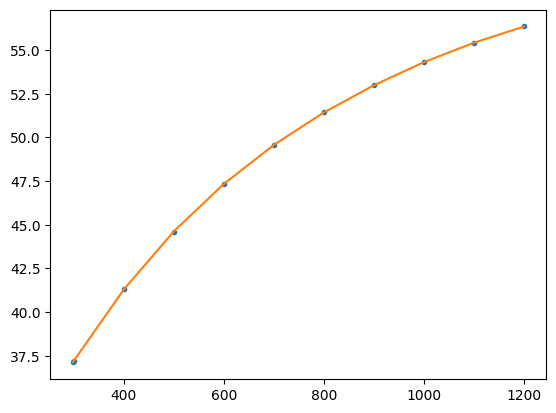

In [10]:
x = np.array(temperatures)
y = np.array(expData)
z = np.polyfit(x, y, 4)
print(z)
p = np.poly1d(z)

print('CpA_fitted', p[0])
print('CpB_fitted', p[1])
print('CpC_fitted', p[2])
print('CpD_fitted', p[3])
print('CpE_fitted', p[4])

xp = np.linspace(-2, 6, 100)
plt.plot(x, y, '.', x, p(x), '-')

## Automatic fitting